# BCA Car Price Prediction by Jonathan Lampkin - EDA

## Overview
This notebook is used for Exploratory Data Analysis to understand the dataset.




## Install Packages


In [2]:
# Install all dependencies from requirements files
%pip install -Uq pip
%pip install -r ../requirements-dev.txt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from IPython.display import HTML, display
import re
from unidecode import unidecode

import os
os.makedirs("artifacts", exist_ok=True)



## Load Data


In [4]:
df = pd.read_csv("../data/EUDS_CaseStudy_Pricing.csv")

# Quick info and validation
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18575 entries, 0 to 18574
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   vehicleID         18575 non-null  object
 1   registrationDate  18575 non-null  object
 2   kilometers        18575 non-null  int64 
 3   colour            18556 non-null  object
 4   aestheticGrade    18575 non-null  object
 5   mechanicalGrade   18575 non-null  object
 6   saleDate          18575 non-null  object
 7   make              18575 non-null  object
 8   model             18575 non-null  object
 9   doorNumber        18575 non-null  int64 
 10  type              18575 non-null  object
 11  fuel              18575 non-null  object
 12  transmission      18575 non-null  object
 13  yearIntroduced    18575 non-null  int64 
 14  cylinder          18575 non-null  int64 
 15  cubeCapacity      18575 non-null  int64 
 16  powerKW           18575 non-null  int64 
 17  powerHP     

## YData Profiling 

In [ ]:
import subprocess, sys, textwrap, tempfile, os
code = textwrap.dedent("""
from ydata_profiling import ProfileReport
import pandas as pd
ProfileReport(pd.read_csv('../data/clean_data.csv').sample(2000, random_state=0),
              minimal=True, explorative=False, pool_size=1, progress_bar=False
).to_file('artifacts/eda_report_clean.html')
print('OK')
""")
fd, tmp = tempfile.mkstemp(suffix=".py"); os.close(fd)
with open(tmp, "w") as f: f.write(code)
subprocess.run([sys.executable, tmp], check=True, cwd=os.path.dirname(tmp))
print("Wrote artifacts/eda_report_clean.html")

In [13]:
# report = ProfileReport(df, title="EDA Car Prices", explorative=True)

# # Save report to HTML
# html_path = "artifacts/eda_report.html"
# report.to_file(html_path)

# from IPython.display import HTML, display
# display(HTML(report.to_html()))

df_clean = pd.read_csv("../data/clean_data.csv")

report = ProfileReport(
    df_clean,
    title="EDA Car Prices (clean)",
    minimal=True,
    explorative=False,
    pool_size=1,              # disable multiprocessing
    progress_bar=False,
    correlations={            # skip heavy correlations
        "pearson": {"calculate": False},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    },
    interactions={"targets": False, "continuous": False},
    duplicates={"head": 0},
    missing_diagrams={"heatmap": False, "dendrogram": False, "matrix": False, "bar": True},
)

html_path = "artifacts/eda_report_clean.html"
report.to_file(html_path)     # do not display in notebook
print("Wrote:", html_path)

ValidationError: 1 validation error for Settings
interactions -> targets
  value is not a valid list (type=type_error.list)

## Oldschool (Manual) EDA


In [6]:
# European Dataset, correcting non-ascii characters (mostly for make/model)

def clean_ascii(s):
    if pd.isna(s):
        return s
    s = unidecode(str(s))
    s = s.lower()
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()

cat_cols = df.select_dtypes(include=["object", "category"]).columns
if len(cat_cols) > 0:
    df[cat_cols] = df[cat_cols].applymap(clean_ascii)

/tmp/ipykernel_164050/180539827.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cat_cols] = df[cat_cols].applymap(clean_ascii)


In [7]:
print(f"Duplicates: {df.duplicated().sum()}")


Duplicates: 0


## Missing Values Pattern Investigation


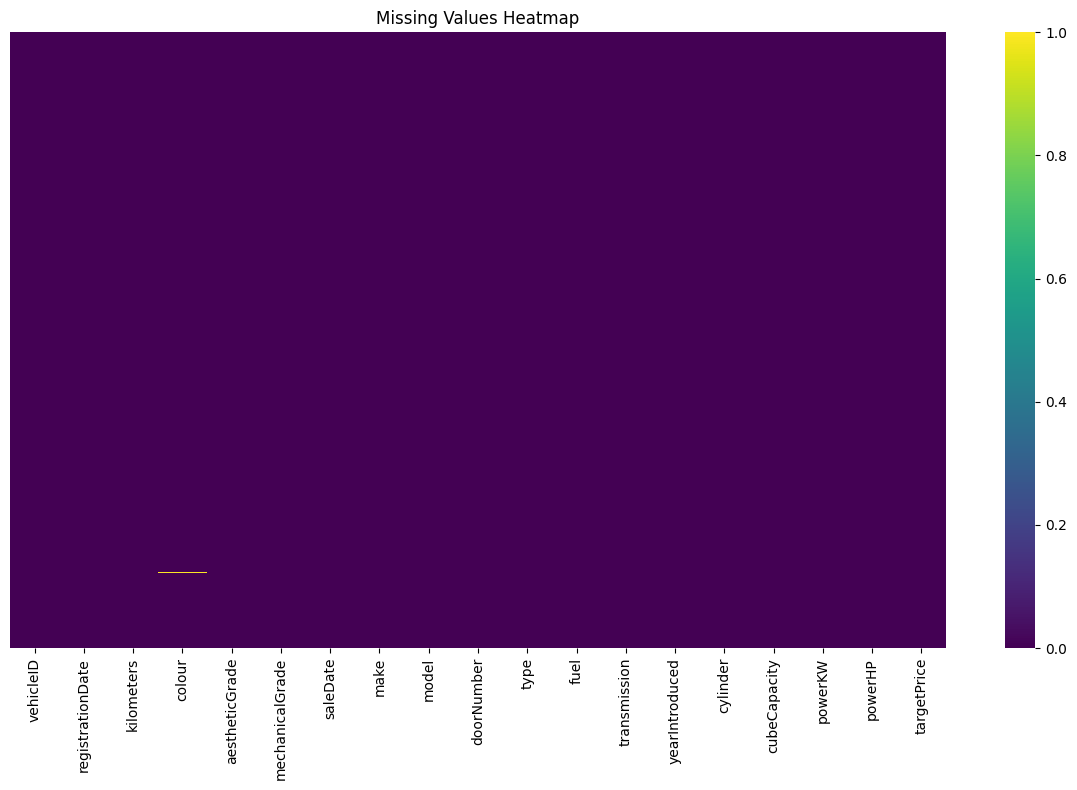

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.savefig('artifacts/missing_values_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()



## TargetPrice EDA

**Notes:** The Target is both heavily skewed and has a long tail. A log transformation is appropriate if we were to use linear models, to avoid extreme values heavily impacting OLS.


Skewness: 2.7
Kurtosis: 10.9


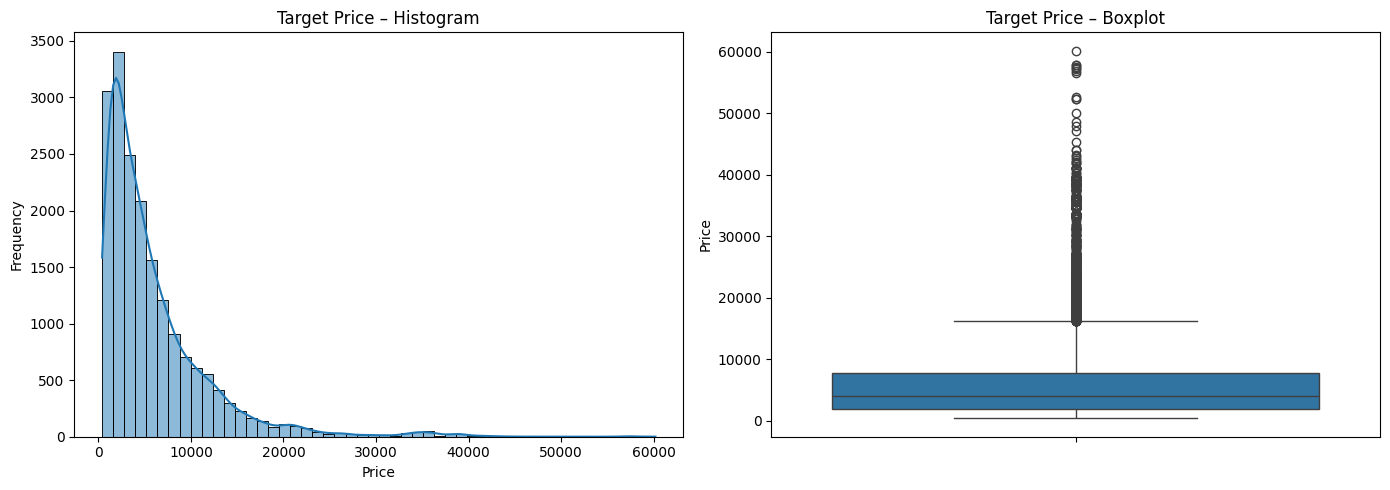

In [9]:
y = df["targetPrice"].astype(float).dropna()
print(f"Skewness: {y.skew():.1f}")
print(f"Kurtosis: {y.kurtosis():.1f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(y, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Target Price – Histogram")
axes[0].set_xlabel("Price"); axes[0].set_ylabel("Frequency")

sns.boxplot(y=y, ax=axes[1], whis=1.5)
axes[1].set_title("Target Price – Boxplot")
axes[1].set_xlabel(""); axes[1].set_ylabel("Price")

plt.tight_layout()
plt.show()


## Histograms

**Notes:**
- Kilometers has a long tail (high kurtosis); investigate outliers.
- `powerKW` and `powerHP` are near-duplicates; keep only one to avoid collinearity.

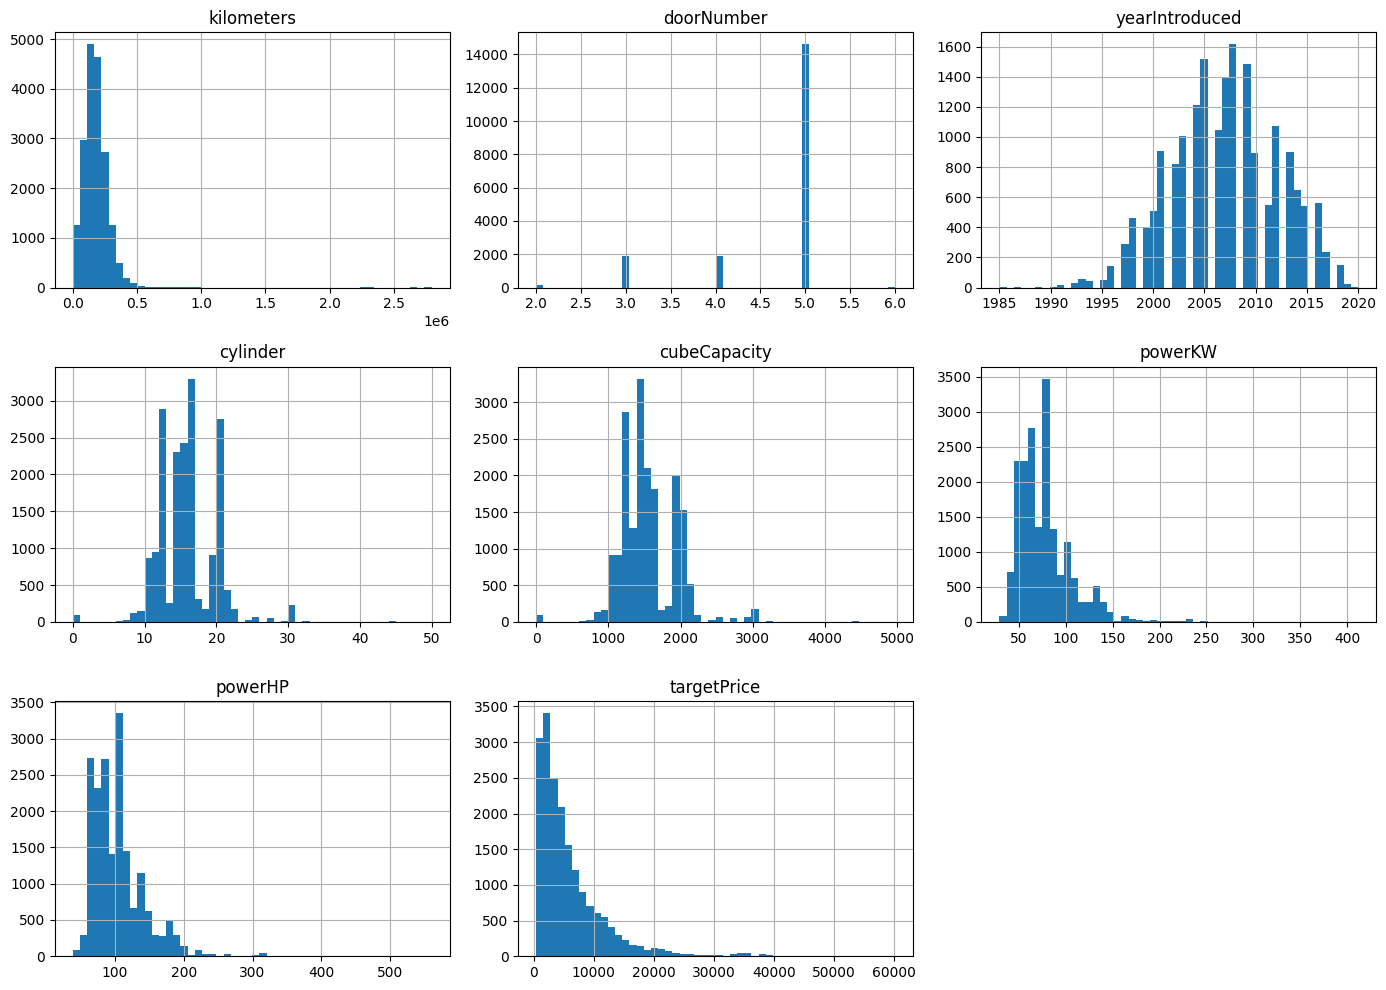

In [10]:
num_cols = df.select_dtypes(include='number').columns
ax = df[num_cols].hist(figsize=(14, 10), bins=50)
plt.tight_layout()
plt.show()


## Box Plots


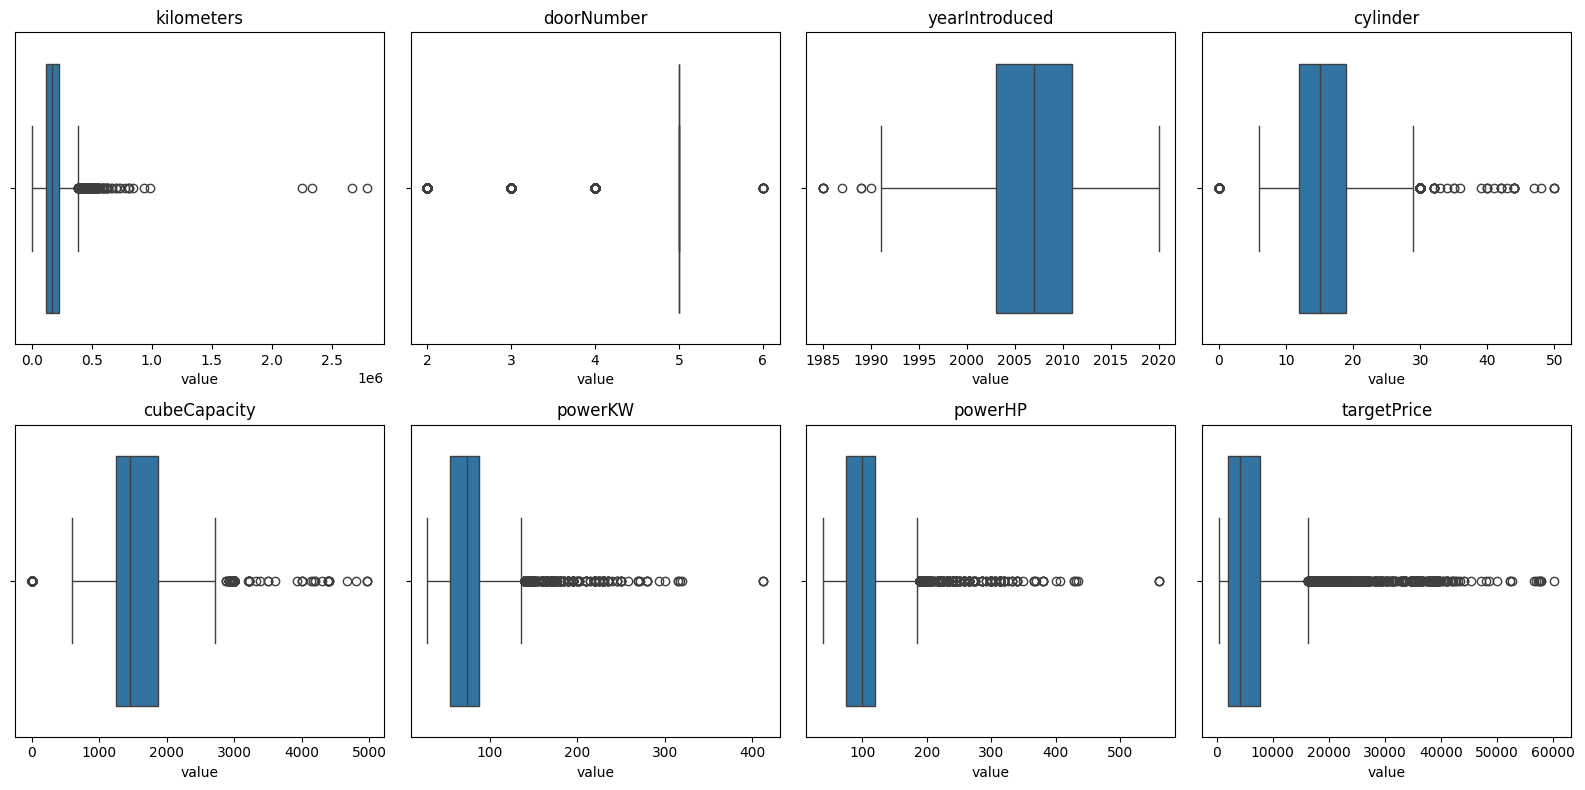

In [11]:
um_cols = df.select_dtypes(include="number").columns
n = len(num_cols)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
axes = axes.flatten()

for ax, c in zip(axes, num_cols):
    sns.boxplot(x=df[c], ax=ax, whis=1.5)
    ax.set_title(c)
    ax.set_xlabel("value")
    ax.set_ylabel("")

for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


## Correlation Analysis


In [12]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, annot_kws={"size":8})
plt.title("Corr Matrix Heatmap")
plt.tight_layout()
plt.show()

NameError: name 'corr_matrix' is not defined

<Figure size 1400x1200 with 0 Axes>

## Categorical Features Countplots


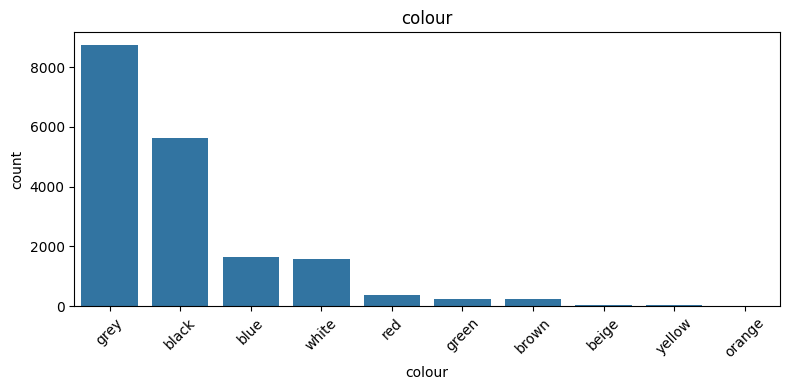

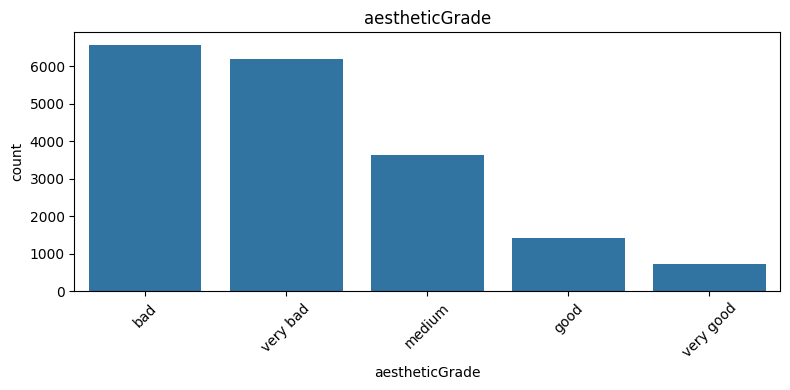

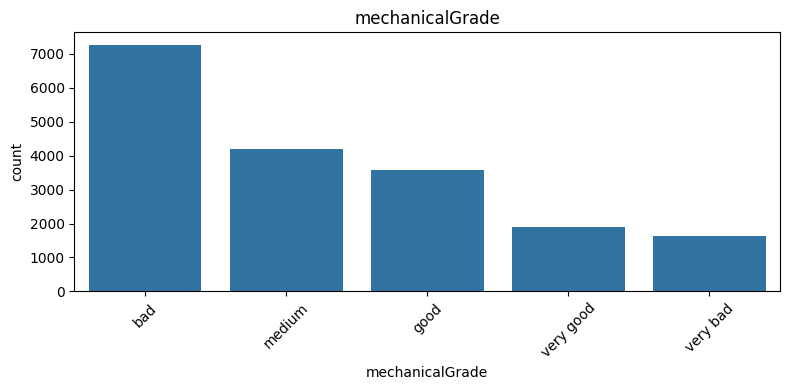

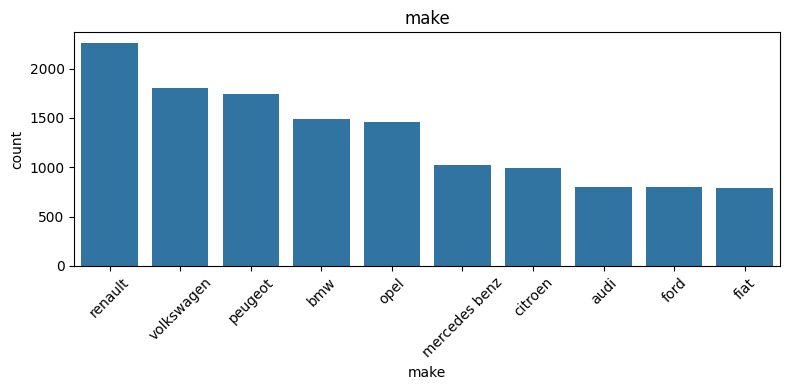

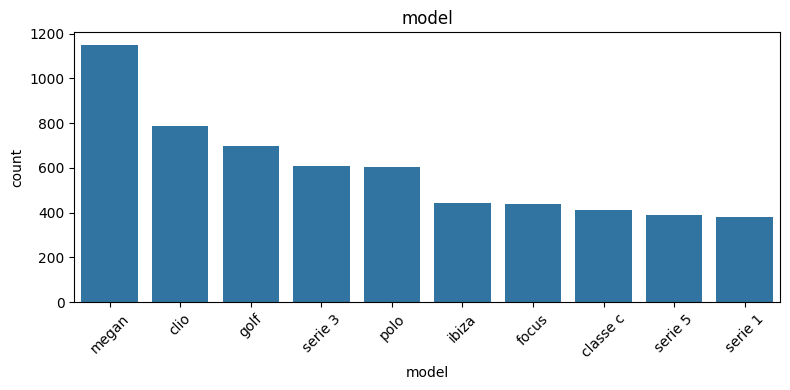

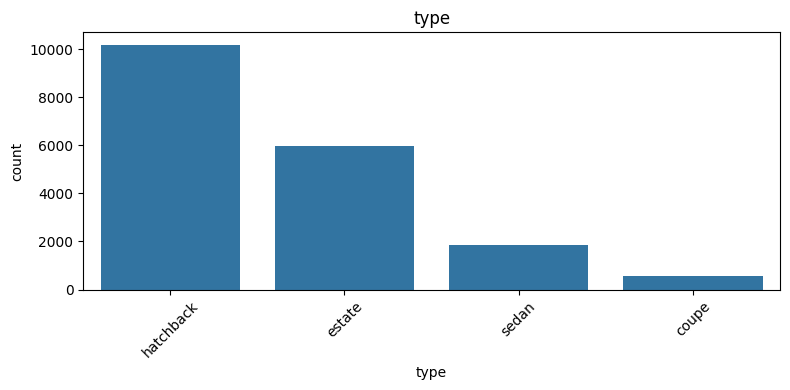

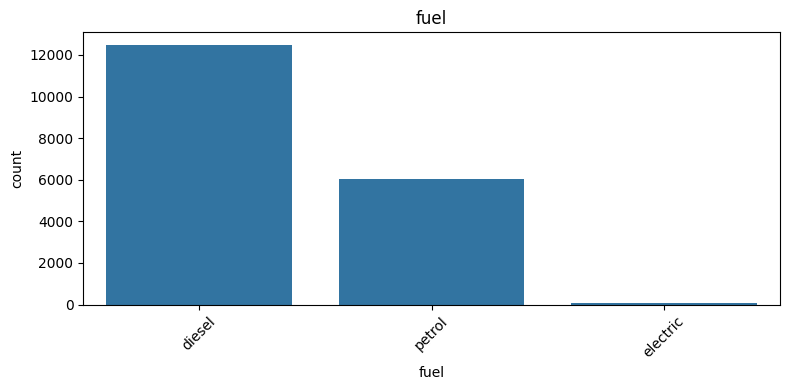

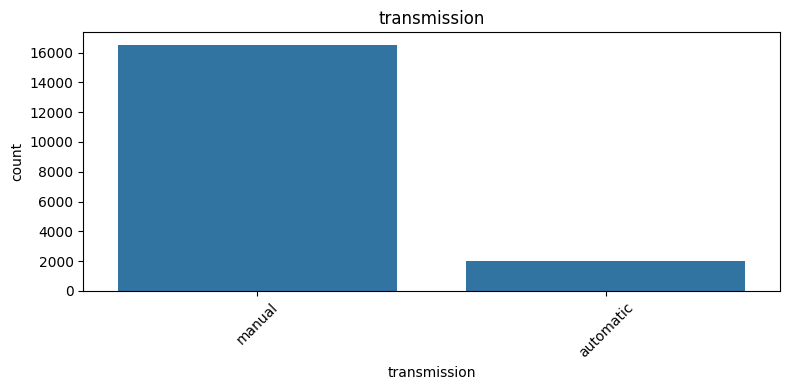

In [ ]:
cat_cols = ['colour','aestheticGrade','mechanicalGrade','make','model','type','fuel','transmission']
cat_cols = [c for c in cat_cols if c in df.columns]

for c in cat_cols:
    s = df[c].fillna("Unknown")
    plt.figure(figsize=(8, 4))
    sns.countplot(x=s, order=s.value_counts().head(10).index)
    plt.title(c)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## YData Profiling on cleaned data


In [ ]:
df_clean = pd.read_csv("../data/clean_data.csv")
report = ProfileReport(df_clean, title="EDA Car Prices (clean)", explorative=True, minimal=True)
# Save and display
html_path = "artifacts/eda_report_clean.html"
report.to_file(html_path)
from IPython.display import HTML, display
display(HTML(report.to_html()))

## Summary of Findings


### Overview
- The data is already quite clean with < 0.1% missing cells and 0 duplicate rows.
- The data is small and fits in RAM; avoid dropping rows given the small n.
- The dataset has a healthy mix of data types.
- `vehicleID` is the primary key with all unique values.

### Alerts
- There are 9 high-correlation alerts; watch for multicollinearity.
- A few features are imbalanced, so underrepresentation may exist in the sample.

### Columns
- **registrationDate:** Proxy for car age; roughly centered around ~2011. Average age ≈ 14 years (assuming registration ≈ build time).
- **kilometers:** Heavily right-skewed with at least one extreme outlier. Remove outliers and log-transform to approximate normality.
- **colour:** Moderately high cardinality. Use model-based feature importance later to decide whether to keep.
- **aestheticGrade:** Low cardinality; likely a modest predictor.
- **mechanicalGrade:** Low cardinality; likely a modest predictor.
- **saleDate:** Correct dtype; useful as an index. Remove outliers.
- **make:** High cardinality; fine for trees, potentially problematic for linear models.
- **model:** High cardinality; fine for trees, likely problematic for linear models (consider binning or exclusion).
- **doorNumber:** Low cardinality; fine as is.
- **type:** Low cardinality; fine as is.
- **fuel:** Low cardinality with underrepresented Electric vehicles.
- **transmission:** Binary; map to 1/0. Automatic is underrepresented.
- **yearIntroduced:** May correlate strongly with age derived from `registrationDate`.
- **cylinder:** Clip outliers; impute or drop nulls.
- **cubeCapacity:** Treat 0 as null; impute with median.
- **powerKW / powerHP:** Likely collinear; drop one.
- **targetPrice:** Predict log(target); consider quantile models.


In [ ]:
df['saleDate'] = pd.to_datetime(df['saleDate'], errors='coerce')
df['registrationDate'] = pd.to_datetime(df['registrationDate'], errors='coerce')

yearintroduced_numeric = pd.to_numeric(df['yearIntroduced'], errors='coerce')
yearintroduced_date = pd.to_datetime(dict(year=yearintroduced_numeric, month=1, day=1), errors='coerce')

outliers = df[(df['saleDate'] < yearintroduced_date) | (df['registrationDate'] > df['saleDate'])]
outliers


NameError: name 'pd' is not defined

In [ ]:
clean_report = ProfileReport(df, minimal=True, explorative=False)
display(HTML(clean_report.to_html()))

In [ ]:
clean = pd.read_csv('../data/clean_data.csv')
print(clean.info())
print(clean.head())

NameError: name 'pd' is not defined